For a given set training noise, compare the relative error over time. This requires evaluation trajectory dumps.

In [6]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline

In [49]:
import os
dump_dir = os.path.abspath('../.log')

def parse_dump(dump):
    ts = dump.get('ts')
    # z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
    true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, true_zt_chaos, pred_zt

def download_runs_sweep(sweep_id):
    api = wandb.Api()
    sweep = api.sweep(sweep_id)
    for run in sweep.runs:
        download_root = os.path.join(dump_dir, sweep.name, run.name)
        for f in run.files():
            if f.name == 'data.pt':
                print(run.name)
                fpath = os.path.join(download_root, f.name)
                if not os.path.isfile(fpath):
                    f.download(root=download_root)
                yield run.name, run.config, parse_dump(torch.load(fpath))

def download_runs(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        for f in run.files():
            if f.name == 'data.pt':
                fpath = os.path.join(download_root, f.name)
                if not os.path.isfile(fpath):
                    f.download(root=download_root)
                yield run.name, run.config, parse_dump(torch.load(fpath))

## Metric computations

Everything that needs to be computed for final graphs.

In [8]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

def compute_likelihood(ref, pred):
    '''
    Likelihood of the reference under Gaussian estimated
    by the samples, factored over time.
    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    batch_shape = pred.shape[:3]

    pred_mu = pred.view(*batch_shape, -1).mean(dim=0)
    pred_std = pred.view(*batch_shape, -1).std(dim=0) + 1e-6
    pred_std[torch.isnan(pred_std)] = 1e-6
    pred_dist = torch.distributions.MultivariateNormal(pred_mu, pred_std.diag_embed())

    log_prob = pred_dist.log_prob(ref.view(*ref.shape[:2], -1))  ## N x T
    return log_prob

def compute_lad_fit(ts, rel_err):
    '''Returns the line
    ts: T
    rel_err: N x T
    '''
    coef = np.polyfit(ts.cpu().numpy(), rel_err.cpu().numpy().T, 1)  # 2 x N
    coef = torch.from_numpy(coef).float()
    line = coef[0].unsqueeze(-1) * ts.unsqueeze(0) + coef[1].unsqueeze(-1)  # N x T
    return line

In [54]:
hnn_run_ids = \
[
    "1ses30rm",
    "2omu835z",
    "4n64ja28",
    "3ic27vfe",
    "1okmdkwi",
    "12js6tjb",
    "2fwzkn3m",
    "2wq8uj48",
]

coupled_run_ids = \
[
    "23iuk9u7",
    "1ne1i3p0",
    "3kzh427l",
    "2uq4gkst",
    "3rbs0xt7",
    "31fd7phr",
    "2jcqg5x3",
    "hq4eedxd"
]

magnet_run_ids = \
[
    "1pzcfexn",
    "2q2u2yv0",
    "2zy8xe5f",
    "xt411u03",
    "3oe4e6d9",
    "125ocz96",
    "3klrl9h0",
    "7ps3zbcc"
]

{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 1000}
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 500}
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 100}
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 20}
{'C': 25, 'lr': 0.003, 'tau': 10, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 1000}
{'C': 25, 'lr': 0.003, 'tau': 10, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 500}
{'C': 25, 'lr': 0.003, 'tau': 10, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 100}
{'C': 25, 'lr': 0.003, 'tau': 10, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 20}
[tensor(0.3544), tensor(0.3884), tensor(0.4202), tensor(0.5191)]
[tensor(0.3576), tensor(0.3746), tensor(0.3959), tensor(0.4113)]


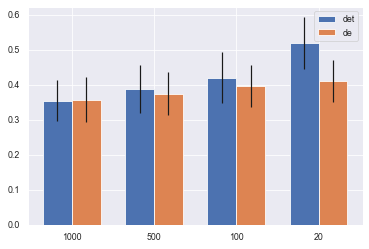

In [81]:
det_vals, det_errs = [], []
de_vals, de_errs = [], []
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt) in download_runs(hnn_run_ids):
    print(cfg)
    
    end_idx = len(ts) // 5
    ts = ts[:end_idx]
    true_zt = true_zt[:,:end_idx]
    pred_zt = pred_zt[:,:,:end_idx]
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
#     print(rel_err[rel_err.isnan()])
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std() / 5
    
#     print(cfg)
    if 'uq_type' in cfg and cfg['uq_type'] == "deep-ensemble":
        de_vals.append(mean)
        de_errs.append(err)
    else:
        det_vals.append(mean)
        det_errs.append(err)
        
labels = [1000, 500, 100, 20]

x = np.arange(len(labels))
width = 0.35

print(det_vals)
print(de_vals)
plt.bar(x - width/2, det_vals, width, yerr=det_errs, label="det")
plt.bar(x + width/2, de_vals, width, yerr=de_errs, label="de")
plt.xticks(x, labels)
plt.legend()
    
plt.show()

WnB-840259
{'C': 25, 'lr': 0.003, 'tau': 10, 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 1000}


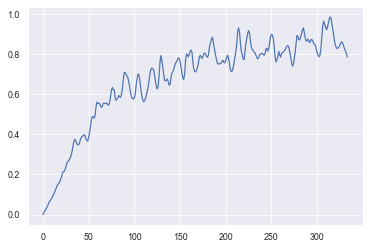

WnB-840258
WnB-840257
{'C': 25, 'lr': 0.003, 'tau': 10, 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 500}


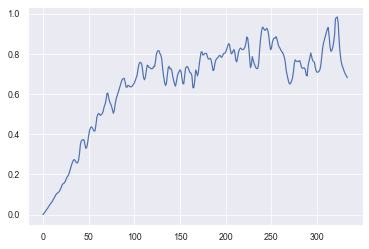

WnB-840256
WnB-840255
{'C': 25, 'lr': 0.003, 'tau': 10, 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 100}


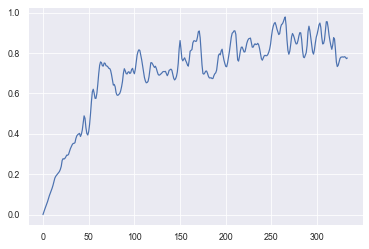

WnB-840254
WnB-840253
{'C': 25, 'lr': 0.003, 'tau': 10, 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 20}


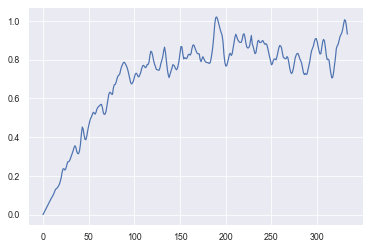

WnB-840252
WnB-840363
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 500}
WnB-840362
WnB-840361
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 100}
WnB-840360
WnB-840359
{'C': 25, 'lr': 0.003, 'tau': 10, 'uq_type': 'deep-ensemble', 'eps_scale': 0.01, 'num_bodies': 3, 'num_epochs': 50, 'n_subsample': 20}
WnB-840358
[tensor(0.5285), tensor(0.4879), tensor(0.5616), tensor(0.5518)]
[tensor(0.3665), tensor(0.3665), tensor(0.3758), tensor(0.3768)]


In [95]:
chnn_det_vals, chnn_det_errs = [], []
chnn_de_vals, chnn_de_errs = [], []
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt) in download_runs_sweep(sweep_id='snym/phy-unc-exps/tc9j22ft'):
    if cfg['n_subsample'] not in [1000, 500, 100, 20]:
        continue
    
    print(cfg)
    
    end_idx = len(ts) // 1
    ts = ts[:end_idx]
    true_zt = true_zt[:,:end_idx]
    pred_zt = pred_zt[:,:,:end_idx]
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    
    plt.plot(range(rel_err.size(-1)), rel_err.mean([0,1]))
    plt.show()
    plt.close()
    
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std() / 5
    
    if 'uq_type' in cfg and cfg['uq_type'] == "deep-ensemble":
        chnn_de_vals.append(mean)
        chnn_de_errs.append(err)
    else:
        chnn_det_vals.append(mean)
        chnn_det_errs.append(err)
    
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt) in download_runs_sweep(sweep_id='snym/phy-unc-exps/4ko04dak'):
    if cfg['n_subsample'] not in [1000, 500, 100, 20]:
        continue
    
    print(cfg)

    end_idx = len(ts) // 2
    ts = ts[:end_idx]
    true_zt = true_zt[:,:end_idx]
    pred_zt = pred_zt[:,:,:end_idx]
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std() / 5
    
    if 'uq_type' in cfg and cfg['uq_type'] == "deep-ensemble":
        chnn_de_vals.append(mean)
        chnn_de_errs.append(err)
    else:
        chnn_det_vals.append(mean)
        chnn_det_errs.append(err)
    
chnn_de_vals = chnn_de_vals[:1] + chnn_de_vals
chnn_de_errs = chnn_de_errs[:1] + chnn_de_errs
    
print(chnn_det_vals)
print(chnn_de_vals)

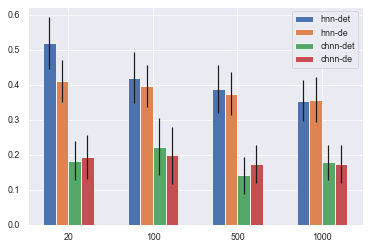

In [83]:
labels = [20, 100, 500, 1000]

x = np.arange(len(labels))
width = 0.15

plt.bar(x - 3*width/2, det_vals[::-1], width, yerr=det_errs[::-1], label="hnn-det")
plt.bar(x - width/2, de_vals[::-1], width, yerr=de_errs[::-1], label="hnn-de")
plt.bar(x + width/2, chnn_det_vals[::-1], width, yerr=chnn_det_errs[::-1], label="chnn-det")
plt.bar(x + 3*width/2, chnn_de_vals[::-1], width, yerr=chnn_de_errs[::-1], label="chnn-de")
plt.xticks(x, labels)
plt.legend()
    
plt.show()

In [3]:
def parse_dump_ou(dump):
    ts = dump.get('ts')
    # z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
    true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')
    var_zt = dump.get('var_zt')
    
    return ts, true_zt, true_zt_chaos, pred_zt, var_zt

def download_runs_ou(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        for f in run.files():
            if f.name == 'data.pt':
                fpath = os.path.join(download_root, f.name)
                if not os.path.isfile(fpath):
                    f.download(root=download_root)
                yield run.name, run.config, parse_dump_ou(torch.load(fpath))

In [42]:
def trace_plot(t, y, ax, std=None, kind='region', color='black', min_y=-np.inf, max_y=np.inf):
    '''
    Arguments:
        zt: Assumes zeroth dimension is number of samples.
        ax: Matplotlib Axis
        pos: Positive quantity flag (for range bounds)
    '''
    assert kind in ['region', 'bound']

    mu = np.mean(y, axis=0)
    if std is None:
        std = np.std(y, axis=0)

    ax.plot(t, mu, c=color)

    if y.shape[0] == 1 and std is None:
        return

    lower = np.clip(mu - 2. * std, min_y, max_y)
    upper = np.clip(mu + 2. * std, min_y, max_y)
    
    if kind == 'region':
        ax.fill_between(ts, lower, upper, color=color, alpha=0.3)
    elif kind == 'bound':
        ax.plot(np.array([t, t]).T, np.array([lower, upper]).T, c=color, dashes=[6,2])
    else:
        raise NotImplementedError

def generate_trace_plots(ts, true_zt, true_zt_chaos, pred_zt, var_zt=None, pred_zt_chaos=None, n=5):
    '''Generate trace plots for n random initial conditions.
    '''
    n_samples, n_init, T, z_dim, n_body, n_dof = true_zt_chaos.shape

    idx = np.arange(0,n)# np.random.permutation(n_init)[:n]
    true_zt = true_zt[idx]
    true_zt_chaos = true_zt_chaos[:, idx, ...]
    pred_zt = pred_zt[:, idx, ...]

    for init_id in range(n):
        for b_id in range(n_body):
            df = []
            for s_id in range(n_samples):
                for dof_id in range(n_dof):
                    for t in range(T):
                        df.append(('chaos', s_id, dof_id,
                                    ts[t], true_zt_chaos[s_id, init_id, t, 0, b_id, dof_id].item()))

            df = pd.DataFrame(df, columns=['method', 's_id', 'dof_id', 't', 'v'])

            g = sns.relplot(data=df, x='t', y='v', col='dof_id', ci='sd', kind='line', color='gray')

            dof_label = ['x', 'y']
            if n_dof > 2:
                dof_label += ['z']
            for dof_id in range(n_dof):
                g.axes[0][dof_id].clear()  ## hack to clear one std dev plots from sns, but retain axis.

                g.axes[0][dof_id].set_title(f'Body {b_id + 1} $\mid$ Dimension {dof_label[dof_id]}')
                g.axes[0][dof_id].set_xlabel('t')
                
                trace_plot(ts, true_zt[np.newaxis, init_id, :, 0, b_id, dof_id], g.axes[0][dof_id],
                           color=(.2,.2,.2))
                
                trace_plot(ts, true_zt_chaos[:, init_id, :, 0, b_id, dof_id], g.axes[0][dof_id],
                           color=(.5,.5,.5))
                
                if var_zt is not None:
                    trace_plot(ts, pred_zt[:, init_id, :, 0, b_id, dof_id], g.axes[0][dof_id],
                               std=var_zt[init_id, :, 0, b_id, dof_id], color=(.2,.2,1.,.75))
                else:
                    trace_plot(ts, pred_zt[:, init_id, :, 0, b_id, dof_id], g.axes[0][dof_id],
                               color=(.2,.2,1.,.75))
                    
                if pred_zt_chaos is not None:
                    trace_plot(ts, pred_zt_chaos[:, init_id, :, 0, b_id, dof_id], g.axes[0][dof_id],
                           color=(.5,0,0))
                    
#             print(1e5 * var_zt[init_id, :, 0, b_id, dof_id].mean())
                
            plt.show(g.fig)

tensor(0.2831)
tensor(0.4191)


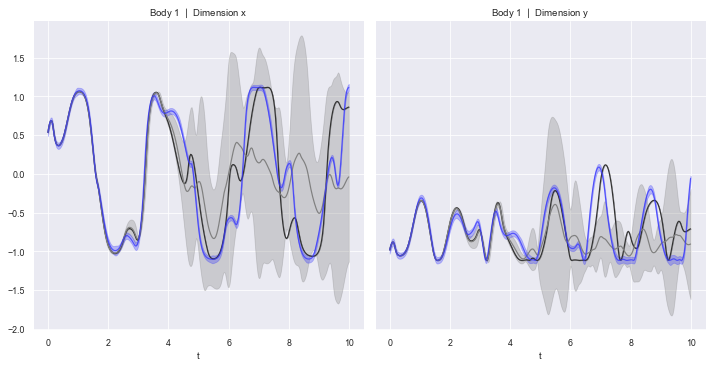

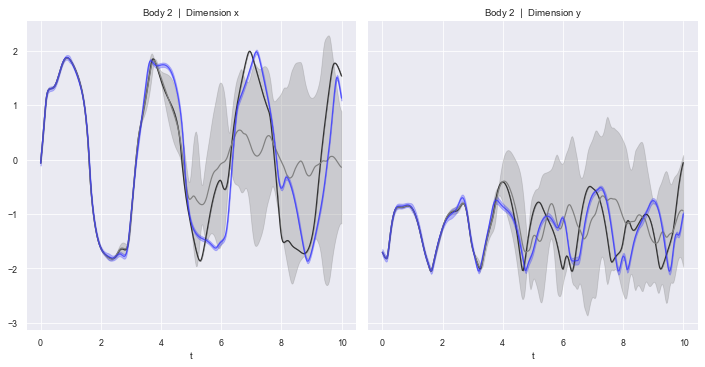

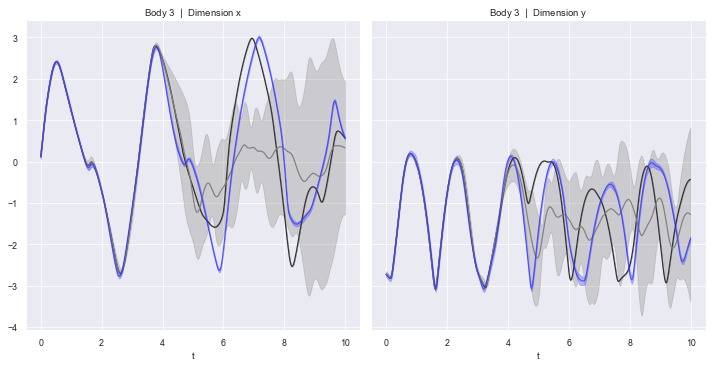

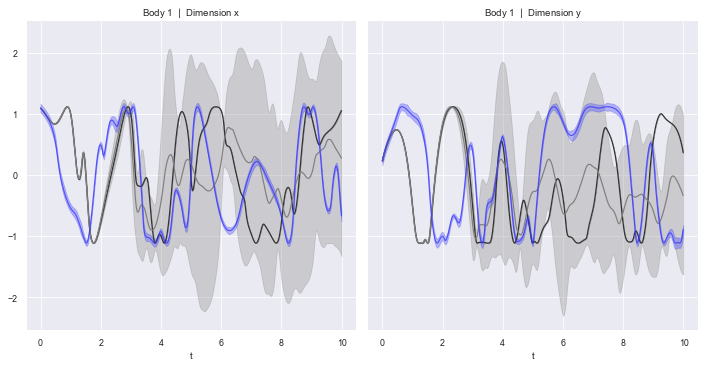

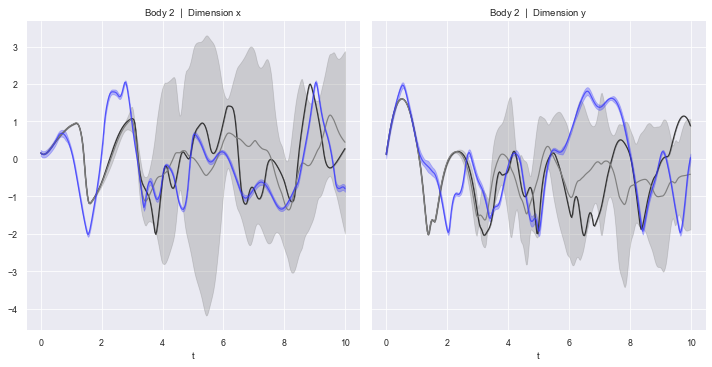

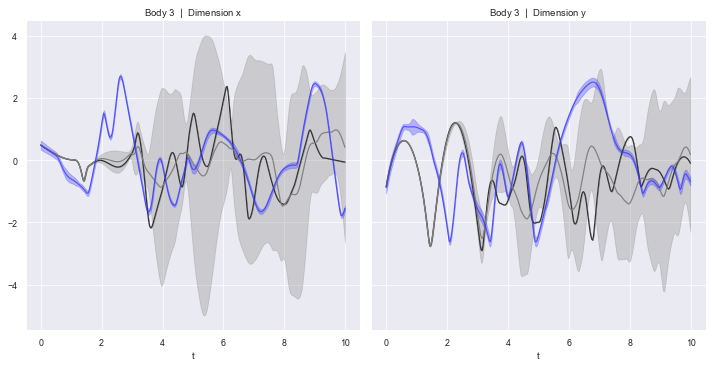

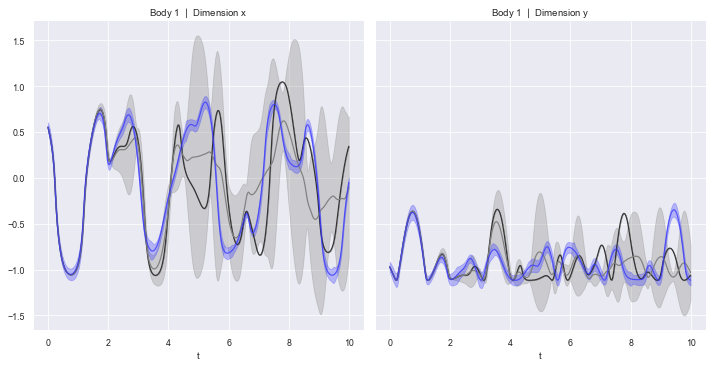

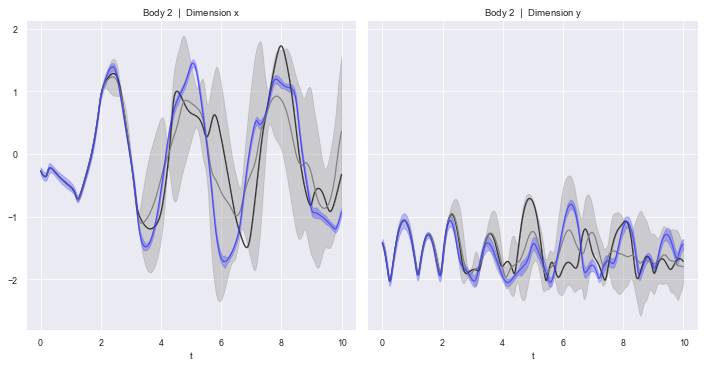

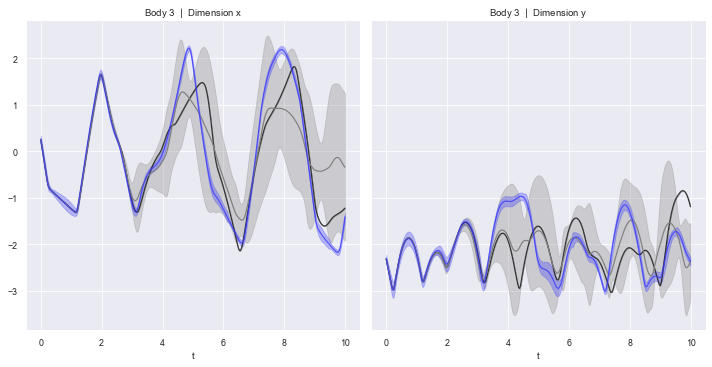

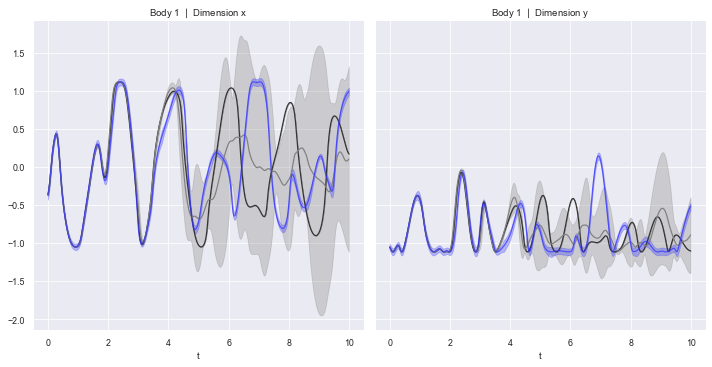

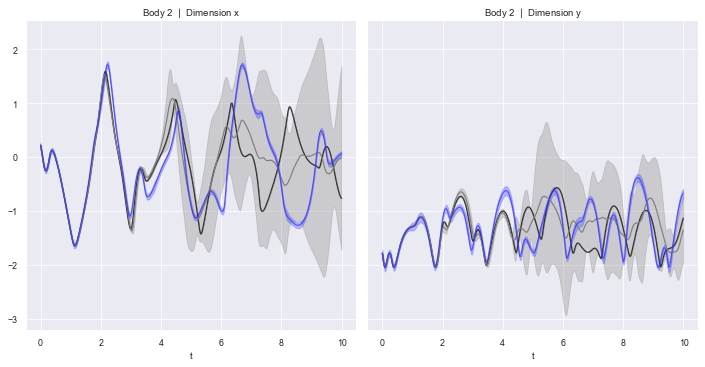

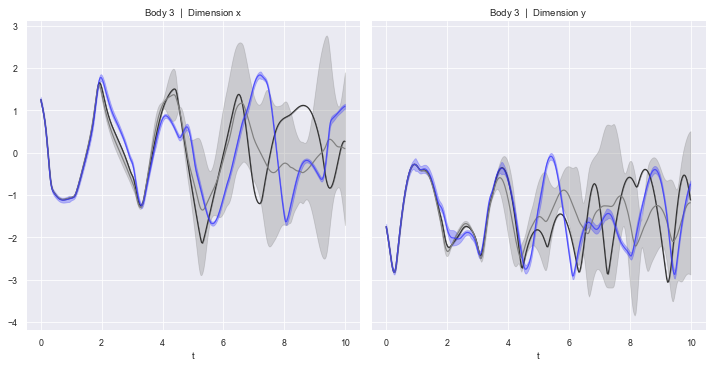

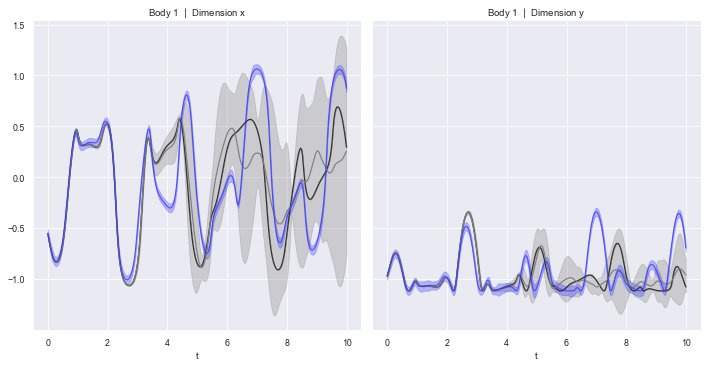

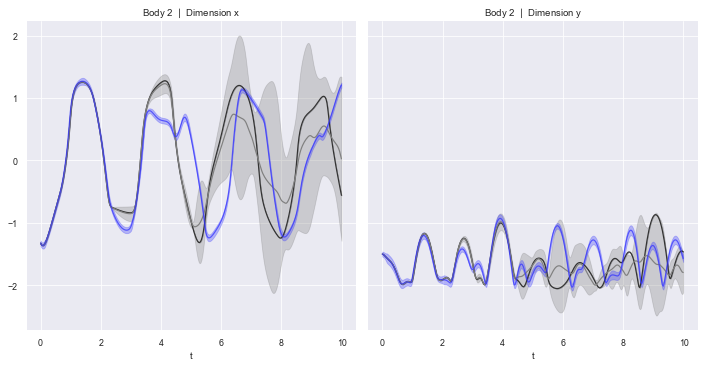

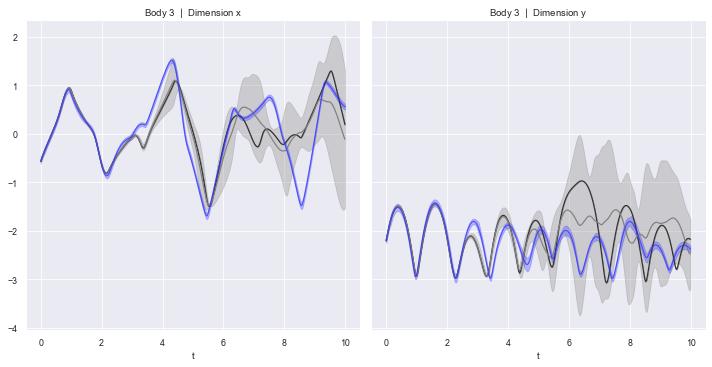

In [25]:
#38i2pkb0
#jnwrv0d2
ou_run_ids = ["24h8zvp4"]

for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt, var_zt) in download_runs_ou(ou_run_ids):
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std()
    
    print(mean)
    print(err)
    
    ts = ts.numpy()
    true_zt = true_zt.numpy()
    true_zt_chaos = true_zt_chaos.numpy()
    pred_zt = pred_zt.numpy()
    var_zt = var_zt.numpy()
    
#     print(var_zt.mean())
    
    generate_trace_plots(ts, true_zt, true_zt_chaos, pred_zt, var_zt)

tensor(0.3040)
tensor(0.4219)


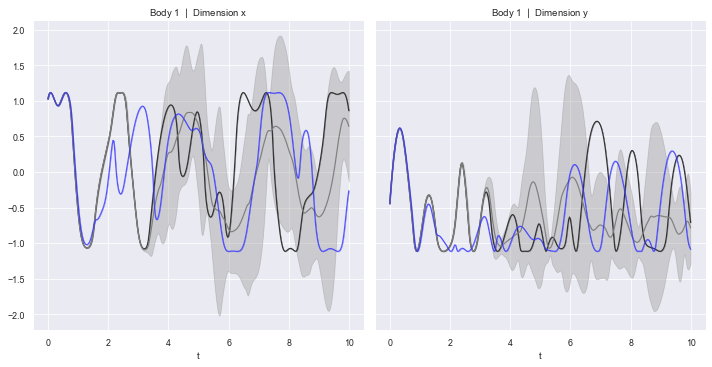

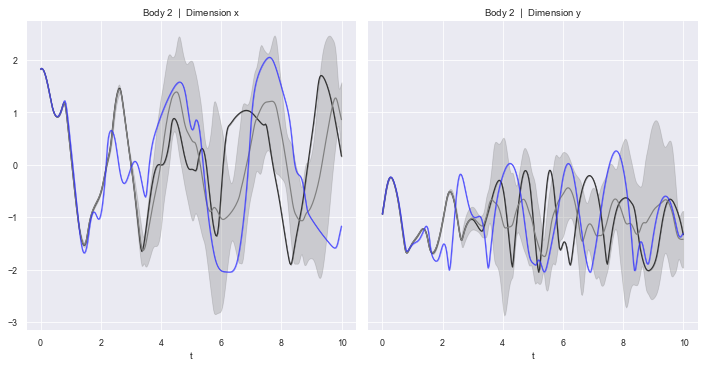

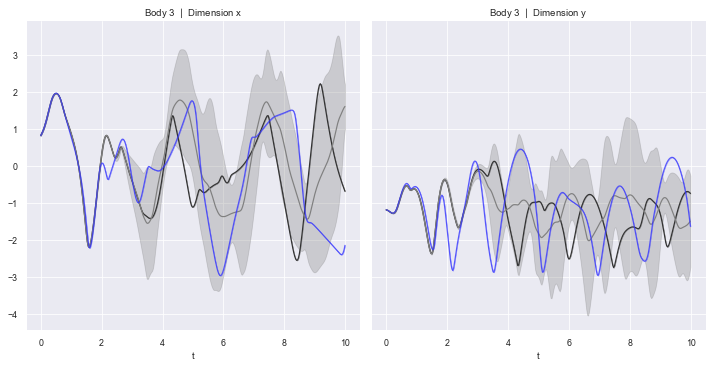

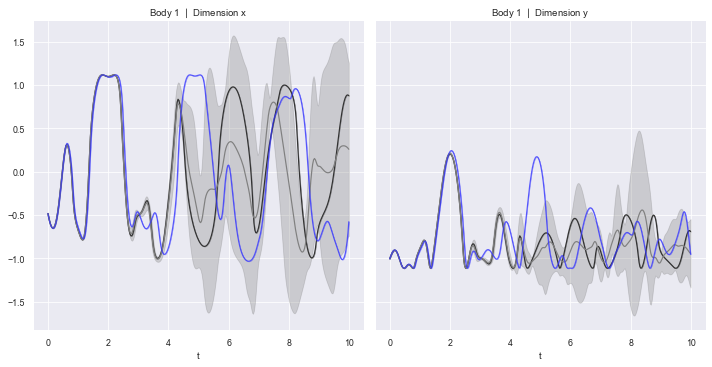

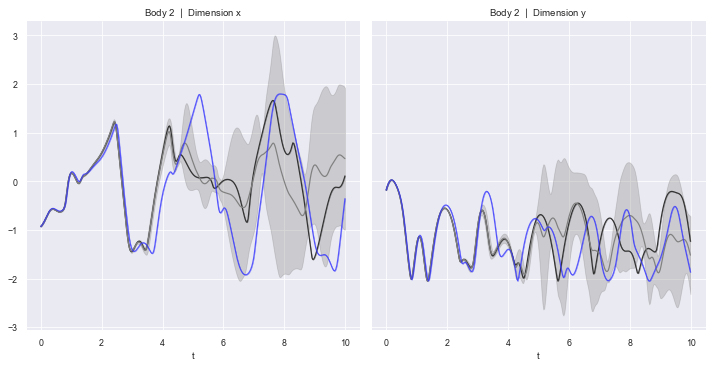

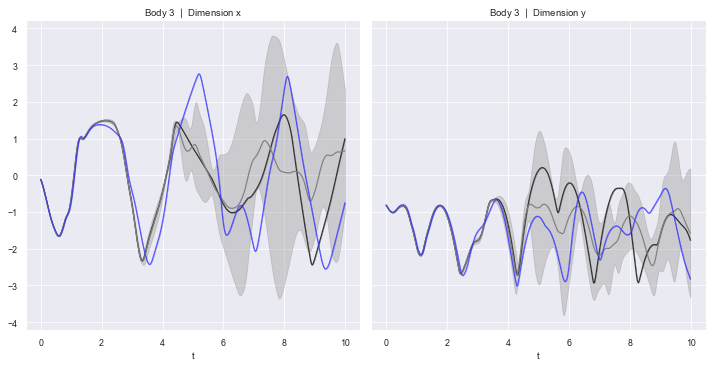

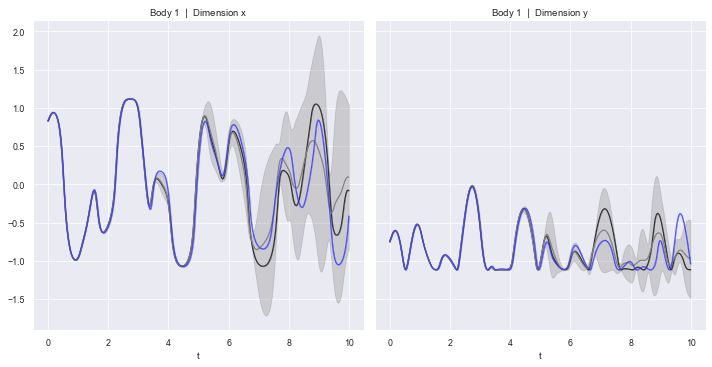

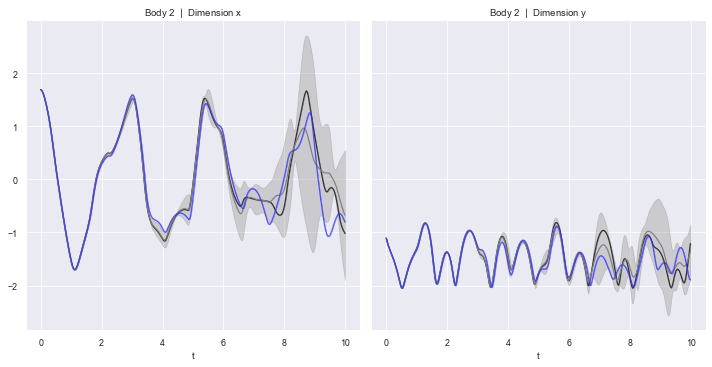

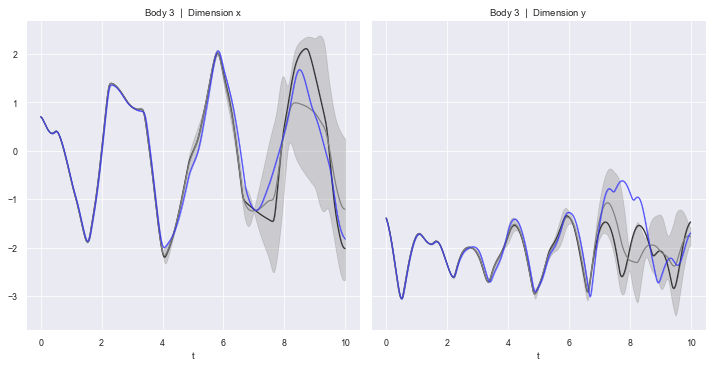

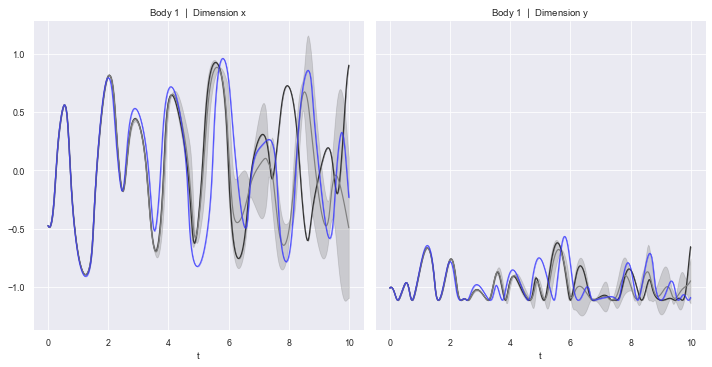

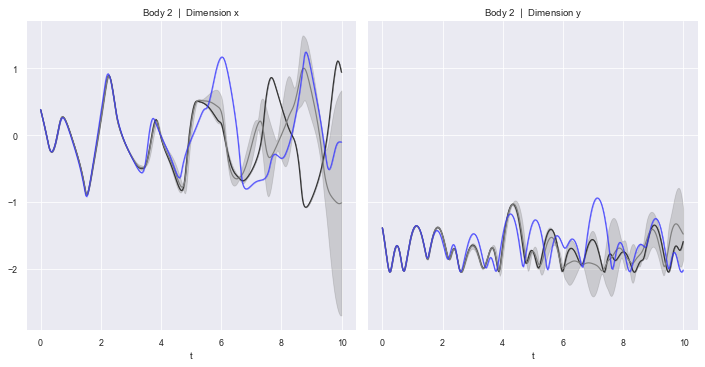

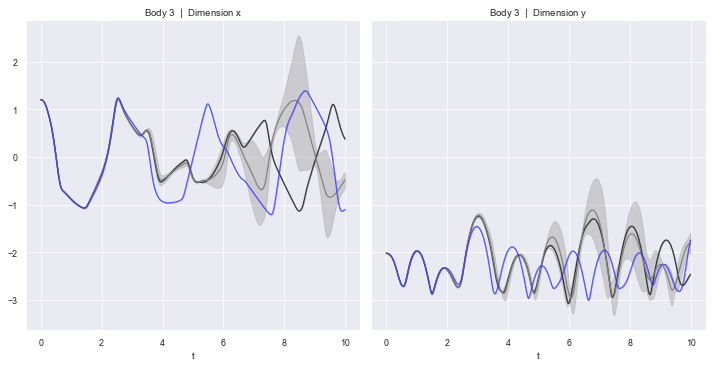

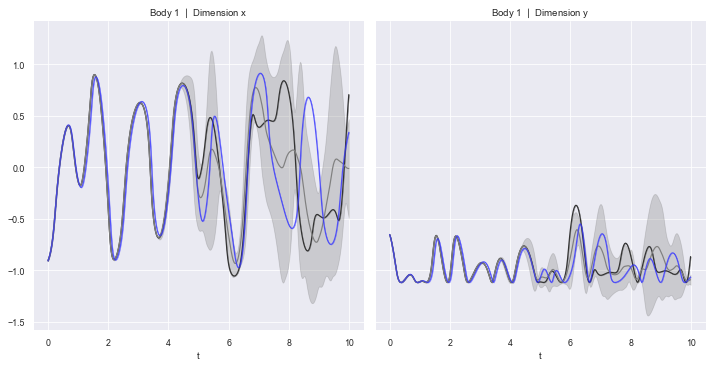

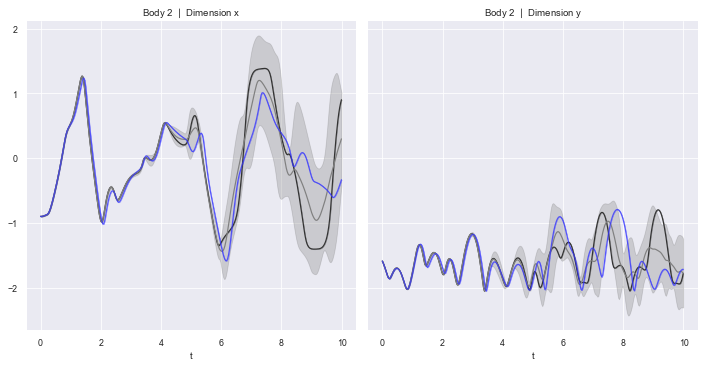

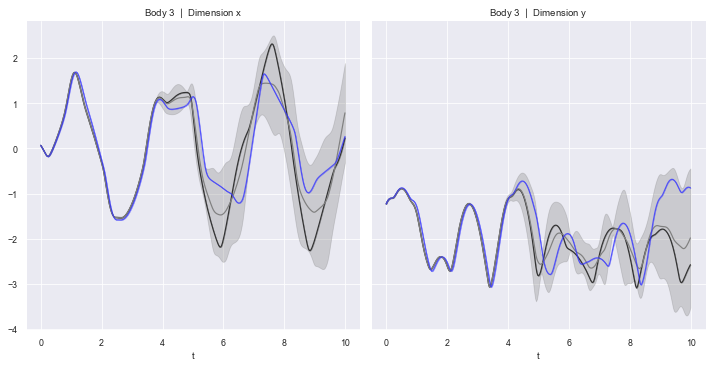

In [26]:
std_run_ids = ["3ejjagz9"]
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt) in download_runs(std_run_ids):
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std()
    
    print(mean)
    print(err)
    
    ts = ts.numpy()
    true_zt = true_zt.numpy()
    true_zt_chaos = true_zt_chaos.numpy()
    pred_zt = pred_zt.numpy()
    
    generate_trace_plots(ts, true_zt, true_zt_chaos, pred_zt)

tensor(0.1714)
tensor(0.4982)


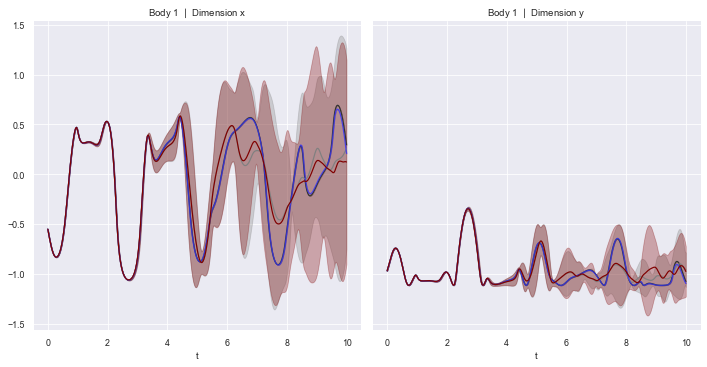

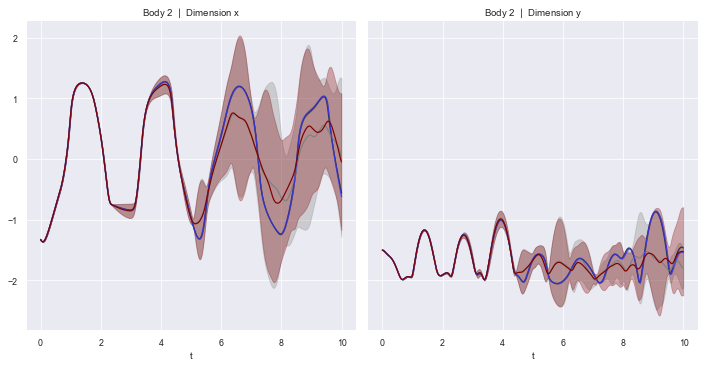

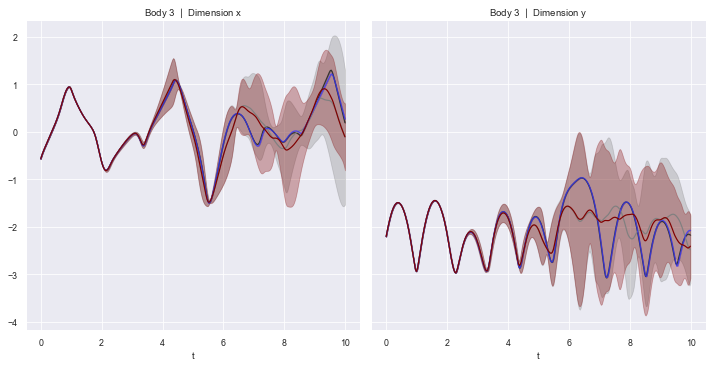

tensor(0.1974)
tensor(0.5249)


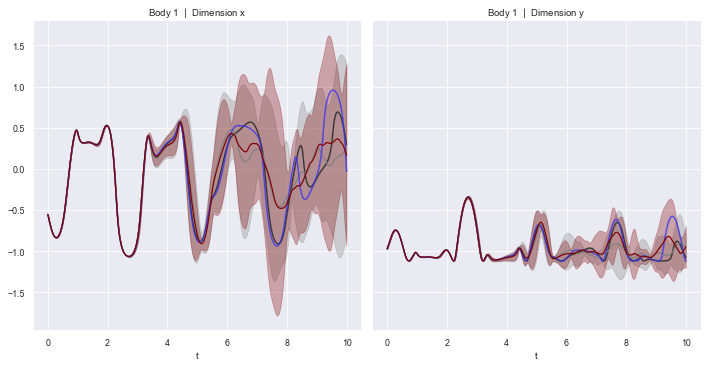

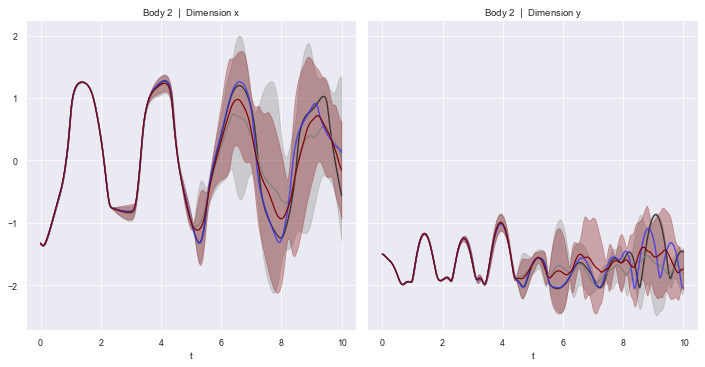

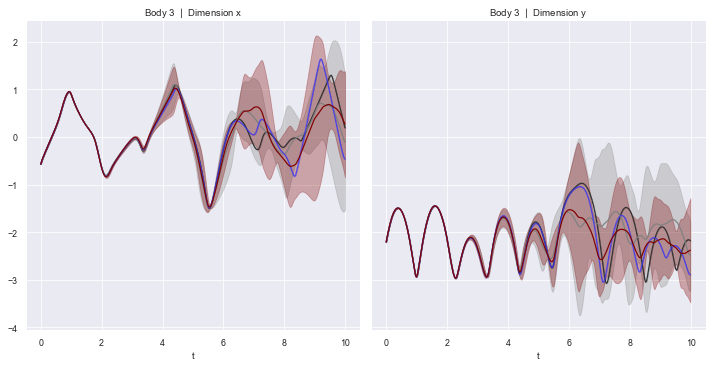

In [43]:
def parse_dump_pred_chaos(dump):
    ts = dump.get('ts')
    # z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
    true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')
    pred_zt_chaos = dump.get('pred_zt_chaos')
    
    return ts, true_zt, true_zt_chaos, pred_zt, pred_zt_chaos

def download_runs_pred_chaos(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        for f in run.files():
            if f.name == 'data.pt':
                fpath = os.path.join(download_root, f.name)
                if not os.path.isfile(fpath):
                    f.download(root=download_root)
                yield run.name, run.config, parse_dump_pred_chaos(torch.load(fpath))

cnf_run_ids = ["6zyohav6", "2rdu9myj"]
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt, pred_zt_chaos) in download_runs_pred_chaos(cnf_run_ids):
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std()
    
    print(mean)
    print(err)
    
    ts = ts.numpy()
    true_zt = true_zt.numpy()
    true_zt_chaos = true_zt_chaos.numpy()
    pred_zt = pred_zt.numpy()
    pred_zt_chaos = pred_zt_chaos.numpy()
    
    generate_trace_plots(ts, true_zt, true_zt_chaos, pred_zt, pred_zt_chaos=pred_zt_chaos, n=1)

tensor(0.3782)
tensor(0.3952)


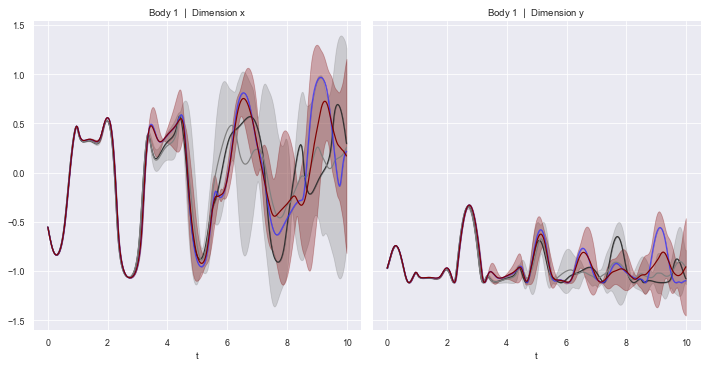

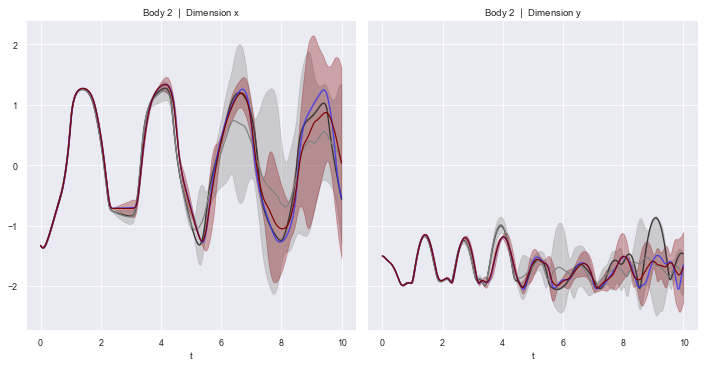

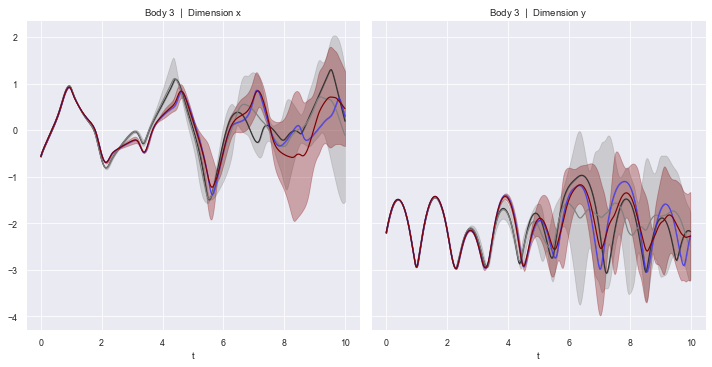

tensor(0.3614)
tensor(0.3802)


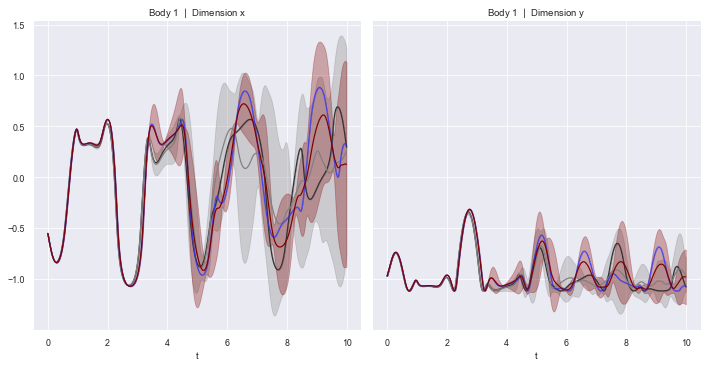

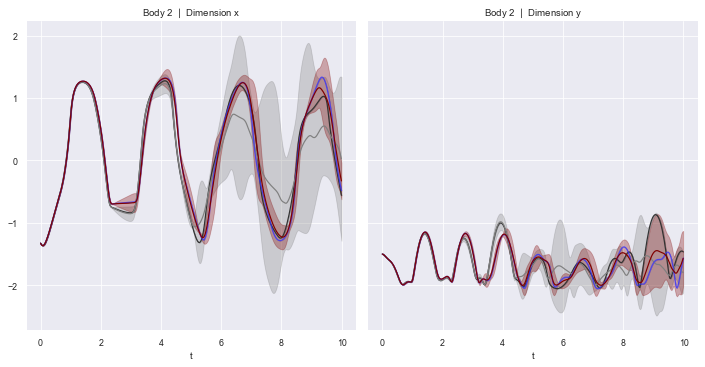

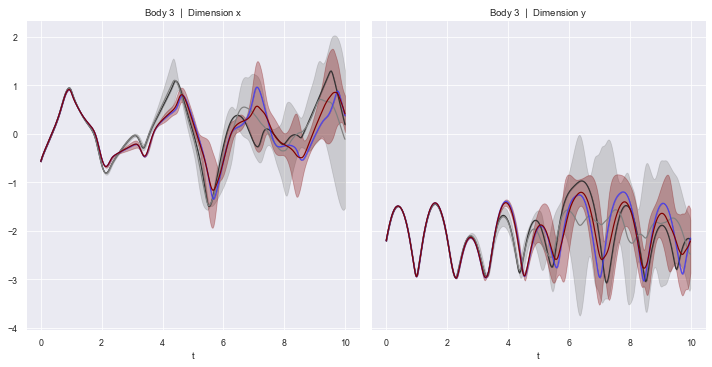

In [45]:
noisy_cnf_run_ids = ["2tv75l74", "q7mqqevs"]
for name, cfg, (ts, true_zt, true_zt_chaos, pred_zt, pred_zt_chaos) in download_runs_pred_chaos(noisy_cnf_run_ids):
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    rel_err[rel_err.isnan()] = 0
    err_geom_mean = compute_geom_mean(ts, rel_err)
    mean = err_geom_mean.mean()
    err = 2 * err_geom_mean.std()
    
    print(mean)
    print(err)
    
    ts = ts.numpy()
    true_zt = true_zt.numpy()
    true_zt_chaos = true_zt_chaos.numpy()
    pred_zt = pred_zt.numpy()
    pred_zt_chaos = pred_zt_chaos.numpy()
    
    generate_trace_plots(ts, true_zt, true_zt_chaos, pred_zt, pred_zt_chaos=pred_zt_chaos, n=1)